# RNA Structure Prediction - Model Development

This notebook develops a deep learning model for RNA structure prediction using preprocessed sequence and structural features.

In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


## 1. Data Loading and Preparation

In [6]:
# Load data
train_df = pd.read_csv('../data/raw/train.csv')
print(f"Loaded {len(train_df)} samples")

# Basic data preprocessing
def preprocess_data(df):
    # Extract sequence features
    sequences = df['sequence'].values
    
    # Extract numerical features
    feature_cols = ['signal_to_noise']
    features = df[feature_cols].values
    
    # Extract targets
    target_cols = [col for col in df.columns if any(x in col for x in 
                  ['reactivity.', 'deg_Mg_pH10.', 'deg_pH10.', 'deg_Mg_50C.', 'deg_50C.'])]
    target_array = df[target_cols].values
    
    # Organize targets into dictionary
    targets = {}
    for i, prefix in enumerate(['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']):
        target_values = target_array[:, i::5]  # Take every 5th column
        targets[prefix] = torch.FloatTensor(target_values)
    
    return sequences, features, targets

sequences, features, targets = preprocess_data(train_df)
print("\nData shapes:")
print(f"Features: {features.shape}")
for name, target in targets.items():
    print(f"{name}: {target.shape}")

Loaded 2400 samples

Data shapes:
Features: (2400, 1)
reactivity: torch.Size([2400, 68])
deg_Mg_pH10: torch.Size([2400, 68])
deg_pH10: torch.Size([2400, 68])
deg_Mg_50C: torch.Size([2400, 68])
deg_50C: torch.Size([2400, 68])


## 2. Model Architecture

In [7]:
class RNADataset(Dataset):
    def __init__(self, sequences, features, targets):
        self.sequences = sequences
        self.features = torch.FloatTensor(features)
        self.targets = targets
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'features': self.features[idx],
            'targets': {k: v[idx] for k, v in self.targets.items()}
        }

# Split data
train_idx, val_idx = train_test_split(range(len(sequences)), test_size=0.2, random_state=42)

# Create datasets
train_dataset = RNADataset(
    sequences[train_idx], 
    features[train_idx],
    {k: v[train_idx] for k, v in targets.items()}
)

val_dataset = RNADataset(
    sequences[val_idx], 
    features[val_idx],
    {k: v[val_idx] for k, v in targets.items()}
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")

Training samples: 1920
Validation samples: 480


In [8]:
class RNAPredictor(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 256):
        super().__init__()
        
        # Feature processing
        self.feature_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Sequence processing
        self.embedding = nn.Embedding(4, hidden_dim)  # A, U, G, C
        self.lstm = nn.LSTM(
            hidden_dim, hidden_dim, 
            bidirectional=True,
            batch_first=True
        )
        
        # Prediction heads
        self.heads = nn.ModuleDict({
            name: nn.Sequential(
                nn.Linear(hidden_dim * 3, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim, 68)
            )
            for name in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 
                        'deg_Mg_50C', 'deg_50C']
        })
    
    def forward(self, sequences, features):
        # Process features
        feature_embed = self.feature_network(features)
        
        # Process sequences
        seq_indices = torch.tensor([
            [{'A':0, 'U':1, 'G':2, 'C':3}[n] for n in seq]
            for seq in sequences
        ]).to(features.device)
        
        seq_embed = self.embedding(seq_indices)
        seq_embed, _ = self.lstm(seq_embed)
        seq_embed = seq_embed.mean(dim=1)  # Average pooling
        
        # Combine embeddings
        combined = torch.cat([seq_embed, feature_embed], dim=1)
        
        # Generate predictions
        return {name: head(combined) for name, head in self.heads.items()}

# Initialize model
model = RNAPredictor(input_dim=features.shape[1]).to(device)
print("Model initialized")

Model initialized


## 3. Training Pipeline

In [9]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    
    for batch in loader:
        sequences = batch['sequence']
        features = batch['features'].to(device)
        targets = {k: v.to(device) for k, v in batch['targets'].items()}
        
        optimizer.zero_grad()
        predictions = model(sequences, features)
        
        loss = sum(F.mse_loss(predictions[k], targets[k]) for k in predictions)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in loader:
            sequences = batch['sequence']
            features = batch['features'].to(device)
            targets = {k: v.to(device) for k, v in batch['targets'].items()}
            
            predictions = model(sequences, features)
            loss = sum(F.mse_loss(predictions[k], targets[k]) for k in predictions)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

# Training loop
n_epochs = 30
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(n_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/30:
Train Loss: 4.4687, Val Loss: 4.3305
Epoch 2/30:
Train Loss: 4.3268, Val Loss: 4.2984
Epoch 3/30:
Train Loss: 4.2810, Val Loss: 4.2879
Epoch 4/30:
Train Loss: 4.2528, Val Loss: 4.2553
Epoch 5/30:
Train Loss: 4.2151, Val Loss: 4.2584
Epoch 6/30:
Train Loss: 4.1956, Val Loss: 4.2453
Epoch 7/30:
Train Loss: 4.1698, Val Loss: 4.2049
Epoch 8/30:
Train Loss: 4.1413, Val Loss: 4.2069
Epoch 9/30:
Train Loss: 4.1295, Val Loss: 4.1815
Epoch 10/30:
Train Loss: 4.1017, Val Loss: 4.2086
Epoch 11/30:
Train Loss: 4.0977, Val Loss: 4.2016
Epoch 12/30:
Train Loss: 4.0770, Val Loss: 4.1723
Epoch 13/30:
Train Loss: 4.0512, Val Loss: 4.1887
Epoch 14/30:
Train Loss: 4.0296, Val Loss: 4.1919
Epoch 15/30:
Train Loss: 4.0072, Val Loss: 4.1884
Epoch 16/30:
Train Loss: 3.9779, Val Loss: 4.1849
Epoch 17/30:
Train Loss: 3.9599, Val Loss: 4.1760
Epoch 18/30:
Train Loss: 3.9310, Val Loss: 4.1780
Epoch 19/30:
Train Loss: 3.8416, Val Loss: 4.1810
Epoch 20/30:
Train Loss: 3.8201, Val Loss: 4.1868
Epoch 21/

## 4. Results Analysis

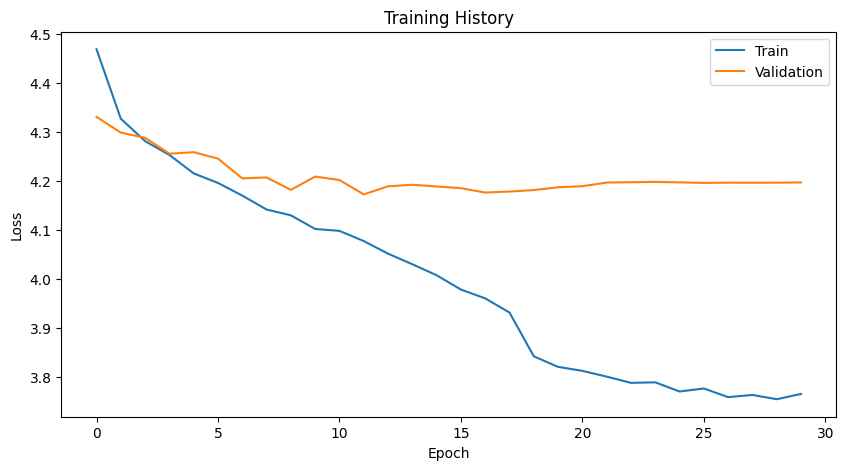


reactivity:
MSE: 0.9322
Correlation: 0.3203

deg_Mg_pH10:
MSE: 0.8071
Correlation: 0.3464

deg_pH10:
MSE: 0.7484
Correlation: 0.4321

deg_Mg_50C:
MSE: 0.6894
Correlation: 0.3397

deg_50C:
MSE: 0.9952
Correlation: 0.2808

Training completed and model evaluated!


/var/folders/33/k5_31_5j3xs93ks88fdb0xb80000gp/T/ipykernel_32296/2733494001.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

In [10]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()

# Load best model and make predictions
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Get predictions
val_predictions = {}
val_targets = {}

with torch.no_grad():
    for batch in val_loader:
        sequences = batch['sequence']
        features = batch['features'].to(device)
        predictions = model(sequences, features)
        
        for k in predictions:
            if k not in val_predictions:
                val_predictions[k] = []
                val_targets[k] = []
            val_predictions[k].append(predictions[k].cpu())
            val_targets[k].append(batch['targets'][k])

# Calculate metrics
for k in val_predictions:
    preds = torch.cat(val_predictions[k]).numpy()
    targets = torch.cat(val_targets[k]).numpy()
    
    mse = np.mean((preds - targets) ** 2)
    corr = np.corrcoef(preds.flatten(), targets.flatten())[0,1]
    
    print(f"\n{k}:")
    print(f"MSE: {mse:.4f}")
    print(f"Correlation: {corr:.4f}")

print("\nTraining completed and model evaluated!")